In [2]:
import torch 
import torchvision
from torch import nn, optim
from torchvision import transforms
from torch.nn import functional as F

import copy
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from glob import glob
from typing import List

In [3]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        ## C,1,1 shape for broadcasting
        self.mean = torch.tensor(mean).view(1,-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(1,-1, 1, 1).to(device)

    def forward(self, img):
        # normalize img
        return (img - self.mean)/self.std

In [4]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_c:int, out_c:int, k_size:int, stride:int, 
                post_in: bool = True, relu: bool = True, deconv: bool = False):
        super(ConvBlock, self).__init__()
        self.post_in = post_in
        self.relu = relu
        self.deconv = deconv
        
        self.reflection_pad = nn.ReflectionPad2d(k_size // 2)
        self.conv = nn.Conv2d(in_c, out_c, k_size, stride)            
        if post_in: self.IN = nn.InstanceNorm2d(out_c,affine=True)
        
    def forward(self, x):
        if self.deconv: x = F.interpolate(x, scale_factor=2)
        y = self.reflection_pad(x)
        y = self.conv(y)
        if self.post_in: y = self.IN(y)
        if self.relu: y = F.relu(y)
        return y

In [5]:
class ResidualBlock(nn.Module):
    
    def __init__(self, c:int):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(c,c,k_size=3,stride=1)
        self.conv2 = ConvBlock(c,c,k_size=3,stride=1,relu=False)
    
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        return x+y

In [6]:
class Feature_Network(nn.Module):
    
    def __init__(self):
        super(Feature_Network, self).__init__()
        self.normalization = Normalization(IMAGENET_MEAN,IMAGENET_STD)
        self.feature_extractor = cnn
    
    def forward(self, img, mode:str):
        block_num, conv_num = 0, 0
        conv_list = []
        
#         img = self.normalization(img)
        for l in self.feature_extractor:
            img = l(img)
            if isinstance(l, nn.ReLU):
                conv_num += 1
                layer_name = f'{block_num+1}_{conv_num}'
                if layer_name in content_layer and mode=='content':
                    conv_list = [img]
                    break
                if layer_name in style_layer and mode=='style':
                    conv_list.append(img)
            elif isinstance(l, nn.MaxPool2d):
                block_num += 1
                conv_num = 0

        return conv_list

In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvBlock(3, 32, k_size=9, stride=1)
        self.conv2 = ConvBlock(32, 64, k_size=3, stride=2)
        self.conv3 = ConvBlock(64, 128, k_size=3, stride=2)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = ConvBlock(128, 64, k_size=3, stride=1,deconv=True)
        self.deconv2 = ConvBlock(64, 32, k_size=3, stride=1,deconv=True)
        self.deconv3 = ConvBlock(32, 3, k_size=9, stride=1,
                                 post_in=False,relu=False)
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.deconv1(y)
        y = self.deconv2(y)
        y = self.deconv3(y)
#         y = y.tanh()
        return y

In [8]:
class customloss(nn.Module):
    
    def __init__(self):
        
        super(customloss, self).__init__()
    
    @staticmethod
    def gram_matrix(x):
        
        a,b,c,d = x.shape
        y = x.reshape(a,b,c*d)
        y = torch.bmm(y,y.transpose(1,2))
        y = y/(b*c*d)
        
        return y
    
    def styleloss(self, g, s_gram):
        g_gram = self.gram_matrix(g)
        
        return F.mse_loss(g_gram, s_gram)
    
    def contentloss(self, g, c):
        
        return F.mse_loss(g, c)
        
    def forward(self, cf: List[torch.Tensor], gf: List[torch.Tensor]):
        content_loss = 0
        style_loss = 0
        
        for g,s in zip(gf,s_gram): style_loss += self.styleloss(g, s[:len(g)])
        content_loss += self.contentloss(gf[style_layer.index(content_layer[0])], cf[0])
                
        return style_loss, content_loss

# setting

In [9]:
torch.backends.cudnn.benchmark = True

In [9]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [10]:
device = 'cuda:0'

In [11]:
style_layer = ['1_1','2_1','3_1','4_1']
content_layer = ['2_1']

In [12]:
image_size = 224
content_weight = 1e5
style_weight = 1e10
lr = 1e-3
epoches = 2
batch_size = 4
acc_iter = 4

In [13]:
transform_x = transforms.Compose([
  transforms.Resize((image_size,image_size)),
#   transforms.CenterCrop((image_size,image_size)),
  transforms.ToTensor()  
])

In [14]:
transform_y = transforms.Compose([
  transforms.Resize((image_size,image_size)),
  transforms.ToTensor()  
])

In [15]:
class imagedataset(torch.utils.data.Dataset):
    
    def __init__(self,root:str,transform=None):
        self.path = glob(root+'*.jpg')
        self.transform = transform
        
    def __len__(self):
#         return 1000
        return len(self.path)
    
    def __getitem__(self,idx):
        pic = Image.open(self.path[idx]).convert('RGB')
        if self.transform: pic = self.transform(pic)
            
        return pic

In [16]:
dataset = imagedataset('../data/VOCdevkit/VOC2012/JPEGImages/',transform_x)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

# model

In [17]:
cnn = torchvision.models.vgg16(pretrained=True).features.to(device).eval()

In [18]:
feature_extractor = Feature_Network()

In [19]:
generator = Generator().to(device)

In [20]:
criterion = customloss()
optimizer = torch.optim.Adam(generator.parameters(),lr=lr)

# start transfer

In [21]:
style_img = transform_y(Image.open('./style2.jpg')).repeat(batch_size,1,1,1).to(device)
with torch.no_grad():
    s_f = feature_extractor(style_img,mode='style')
    s_gram = [criterion.gram_matrix(s) for s in s_f]

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
for e in range(epoches):
    generator.train()
    
    c_score, s_score = 0, 0
    optimizer.zero_grad()
    count_acc = 0
    for img in tqdm(dataloader):
                
        
        img = img.to(device)
        gen_img = generator(img)
        
        with torch.no_grad():
            img_f = feature_extractor(img,mode='content')
        gen_img_f = feature_extractor(gen_img,mode='style')
        
        style_loss, content_loss = criterion(img_f, gen_img_f)
        
        loss = content_weight * content_loss + style_weight * style_loss
        loss = loss/acc_iter
        loss.backward()
        
        count_acc += 1
        if count_acc % acc_iter == 0 :
            optimizer.step()
            optimizer.zero_grad()
        
        c_score += content_loss.item()
        s_score += style_loss.item()
        
    print(f'epoch: {e+1}, content loss: {c_score/len(dataset)}, style loss: {s_score/len(dataset)}')

  0%|                                                                                         | 0/4282 [00:00<?, ?it/s]

epoch: 1, content loss: 0.09695631794772878, style loss: 8.351110548102726e-07


100%|██████████████████████████████████████████████████████████████████████████████| 4282/4282 [30:59<00:00,  2.30it/s]

epoch: 2, content loss: 0.07301442331380217, style loss: 3.9031543057359013e-07


In [29]:
torch.save(generator,'style.pth')

In [ ]:
# torch.onnx.export(feature_extractor,torch.rand(1,3,224,224).cuda(),'a.onnx')

In [56]:
generator = torch.load('sketch.pth').to(device)

# visualize

In [20]:
def tensor_to_np(tensor):
    return tensor.permute(1,2,0).squeeze(0).detach().cpu().numpy() 

In [21]:
def raw_image_load(path:str):
    return torch.from_numpy(np.array(Image.open(path)).transpose(2,0,1)).to(device).div(255)

In [30]:
content_img = raw_image_load('./person.jpg')
style_img = raw_image_load('./style2.jpg')

with torch.no_grad():
    generator.eval()
    output = generator(content_img.unsqueeze(0))
    output = tensor_to_np(output.squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


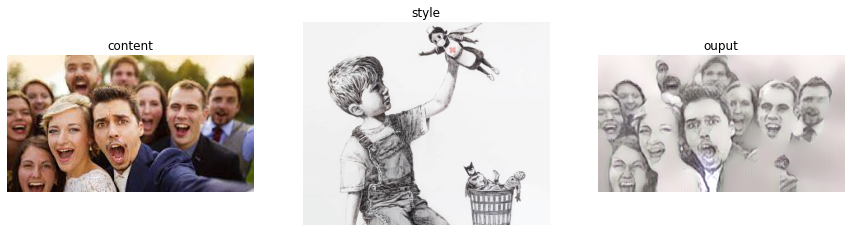

In [31]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('content')
plt.axis('off')
plt.imshow(tensor_to_np(content_img))
plt.subplot(1,3,2)
plt.title('style')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,3,3)
plt.title('ouput')
plt.axis('off')
plt.imshow(output)

In [55]:
cv2.imwrite('output.jpg',output[:,:,::-1]*255)

True

# video

In [13]:
generator = torch.load('sketch.pth').to(device)

In [17]:
vid = cv2.VideoCapture('cat.mp4')

num_frame = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = vid.get(5)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid_writer = cv2.VideoWriter('output.avi', fourcc, fps, (frame_w,frame_h//2))

In [19]:
placeholder = []
for i in tqdm(range(num_frame)):
    ret, frame = vid.read()
    if not ret: break
    frame = frame/255
    frame = frame.astype(np.float32)
    frame = cv2.resize(frame,(frame_w//2,frame_h//2))
    placeholder.append(frame)
    if len(placeholder) == 2:
        batch_frame = np.stack(placeholder)
        placeholder = []
    
        batch_frame = torch.from_numpy(batch_frame).permute(0,3,1,2).to(device)
        with torch.no_grad():
            generator.eval()
            output = generator(batch_frame)
            output = output.permute(0,2,3,1).detach().cpu().numpy()
        batch_frame = batch_frame.permute(0,2,3,1).detach().cpu().numpy()
        compare_list = np.concatenate([batch_frame,output],axis=2)*255
        for compare in compare_list: 
#             vid_writer.write(compare)
              cv2.imwrite('test.jpg',compare)
#             plt.imshow(compare)
        if i == 100: break

  8%|██████▍                                                                        | 240/2936 [00:21<04:03, 11.07it/s]


KeyboardInterrupt: 

In [59]:
vid.release()
vid_writer.release()